# [HW] MNIST

https://www.kaggle.com/competitions/mnist-sai

In [367]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # progress bar

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [368]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [369]:
# Define Parameters
NUM_CLASS = 10
IMG_SIZE = 28
CHANNEL = 1
BATCH_SIZE = 128

#### Prepare Dataset

In [370]:
# download from google drive
# !pip install --upgrade gdown
# !gdown --id '1Pb9lxPjXBEq4O8KMzdemqehRtp_jr-Wy' --output mnist.npz

In [371]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.x_data = data
        self.y_label = label
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        img = self.x_data[idx]
        img = self.transform(img)

        label = self.y_label[idx]
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [372]:
# Load Data from file
with np.load('mnist.npz', allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test = f['x_test']

all_dataset = MNISTDataset(x_train, y_train)

In [373]:
# number of data
len(all_dataset)

60000

In [374]:
# split dataset
# from sklearn.model_selection import train_test_split

train_ds, val_ds = train_test_split(all_dataset,
                                    test_size=0.2,
                                    random_state=5566)

len(train_ds), len(val_ds)

(48000, 12000)

In [375]:
# get 1 data
x, y = train_ds[0]
print(type(x), type(y))
print(x.shape, y.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 28, 28]) torch.Size([])


In [376]:
# Dataloader

train_loader = torch.utils.data.DataLoader(train_ds,
                                           BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds,
                                         BATCH_SIZE)

#### Build Model

In [377]:
# check GPU availability
torch.cuda.is_available()

True

In [378]:
device = "cuda"

In [379]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # (C, H, W) -> (C*H*W)
        self.base_model = nn.Sequential(
            nn.Linear(in_features=IMG_SIZE**2, out_features=64), # (C*H*W) -> (64)
            nn.ReLU(),
            nn.Linear(64, 128), # (64) -> (128)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASS), # (128) -> NUM_CLASS
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.base_model(x)
        return logits

In [380]:
# init model and move to GPU device
model = NeuralNet().to(device)

In [381]:
# Use torchsummary to print advanced info
import torchsummary

torchsummary.summary(model, input_size=(x.shape[0], x.shape[1], x.shape[2]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                  [-1, 128]           8,320
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 76,362
Trainable params: 76,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.29
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


#### Training

In [382]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = model.to(device)

Using device: cuda


In [383]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.0008, # learning rate
)

In [384]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to device

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [385]:
EPOCHS = 20
logs = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.5455, train_acc: 0.839     val_loss: 0.2927, val_acc: 0.914 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 0.2563, train_acc: 0.924     val_loss: 0.2174, val_acc: 0.936 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 0.1977, train_acc: 0.940     val_loss: 0.2030, val_acc: 0.939 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 3     train_loss: 0.1591, train_acc: 0.951     val_loss: 0.1596, val_acc: 0.953 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 4     train_loss: 0.1341, train_acc: 0.958     val_loss: 0.1537, val_acc: 0.955 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 5     train_loss: 0.1185, train_acc: 0.963     val_loss: 0.1393, val_acc: 0.958 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 6     train_loss: 0.1068, train_acc: 0.966     val_loss: 0.1333, val_acc: 0.959 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 7     train_loss: 0.0934, train_acc: 0.970     val_loss: 0.1373, val_acc: 0.957 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 8     train_loss: 0.0823, train_acc: 0.975     val_loss: 0.1297, val_acc: 0.962 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 9     train_loss: 0.0741, train_acc: 0.976     val_loss: 0.1161, val_acc: 0.966 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 10     train_loss: 0.0693, train_acc: 0.977     val_loss: 0.1230, val_acc: 0.966 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 11     train_loss: 0.0643, train_acc: 0.979     val_loss: 0.1301, val_acc: 0.962 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 12     train_loss: 0.0583, train_acc: 0.981     val_loss: 0.1105, val_acc: 0.969 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 13     train_loss: 0.0517, train_acc: 0.983     val_loss: 0.1254, val_acc: 0.963 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 14     train_loss: 0.0499, train_acc: 0.983     val_loss: 0.1093, val_acc: 0.968 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 15     train_loss: 0.0458, train_acc: 0.985     val_loss: 0.1247, val_acc: 0.967 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 16     train_loss: 0.0405, train_acc: 0.987     val_loss: 0.1539, val_acc: 0.959 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 17     train_loss: 0.0435, train_acc: 0.985     val_loss: 0.1088, val_acc: 0.970 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 18     train_loss: 0.0344, train_acc: 0.988     val_loss: 0.1181, val_acc: 0.970 


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

EPOCH: 19     train_loss: 0.0329, train_acc: 0.988     val_loss: 0.1148, val_acc: 0.972 


#### Logs

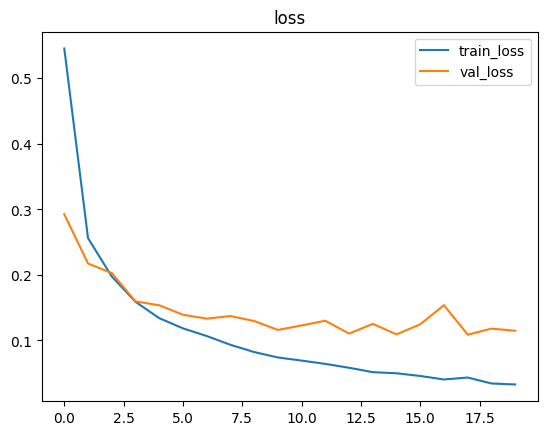

In [386]:
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('loss')
plt.show()

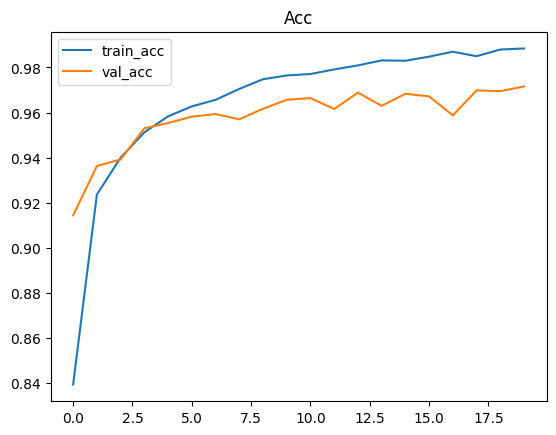

In [387]:
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.title('Acc')
plt.show()

#### Generate file for Kaggle

https://www.kaggle.com/competitions/mnist-sai

In [388]:
class MNISTTestDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.x_data = data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        img = self.x_data[idx]
        img = self.transform(img)
        return img

test_ds = MNISTTestDataset(x_test)
test_loader = torch.utils.data.DataLoader(test_ds, BATCH_SIZE)

In [389]:
# Predict all data
y_pred = []

model.to(device)
model.eval()

with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred)

y_pred = torch.cat(y_pred).argmax(1).cpu().numpy()
y_pred.shape

(10000,)

In [390]:
import pandas as pd

df = pd.DataFrame()
df['Id'] = [str(i) for i in range(len(x_test))]
df['Category'] = y_pred
df.to_csv('result.csv', index=None)
df

,Id,Category
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4
...,...,...
9995,9995,2
9996,9996,3
9997,9997,4
9998,9998,5
